# Exact algorithims

![](https://imgs.xkcd.com/comics/travelling_salesman_problem.png)

## Description
Solving the travelling salesman problem to resolve the lowest weight tour exactly is computationally tractable for graphs with a low node count. Often, getting the actual perfect solution is not required, but in the case it is, two algorithms exist.


## Brute-force
The brute-force search is the simplest algorithim. Consider all permutations of the nodes of the graph, which is the same as all possible tours of a graph (if it is complete). Compute the cost of all of them, and choose the one with the minimum cost. Clearly since we're evaluating all permutations of a graph's nodes, it's complexity is $O(n!)$.

![](https://upload.wikimedia.org/wikipedia/commons/2/2b/Bruteforce.gif)


A python implementation of a brute force search is below

In [1]:
# %load -s brute_force algs.py
def brute_force(p, perf=False):
    import itertools as it
    #Generate all possible tours (complete graph)
    tours = list(it.permutations(p.nodes())) #O(V!)
    costs = []
    
    if not perf:
        cost_data = pd.DataFrame(columns=["$N$", "cost"])
    
    #Evaluate all tours
    for tour in tours:
        cost = 0
        for n1, n2 in zip(tour, tour[1:]): #O(V)
            cost += p[n1][n2]['weight']
        costs.append(cost)
        
    if not perf:
        cost_data = cost_data.append({"$N$" : len(p.nodes()),
                                      "cost" : min(costs),
                                      "opt_tour" : tours[np.argmin(costs)]},
                                     ignore_index = True)
        return (cost_data, pd.DataFrame())     
        
    #Choose tour with lowest cost
    return tours[np.argmin(costs)]


If we visualize how the algorithm progresses, we can pre-emptiveley stop execution of the tour evaluation. Since the order of the permutations is deterministic, we can observe that the cost monotonically decreases.

This monotonic decrease is a result of the `min` function we call on `costs`. In actuality, since we're evaluating all tours, and only storing the smallest one (a `reduce`), we make no assumptions about the structure of the graph. One can see that all edge evaluations are seperate from one another, so our final evaluation is equally likeley to be the lowest-weight tour as the last

Let's set up our visualization, creating a random euclidean 2D graph, and seeing how it performs as we vary $N$, the tour at which it stops evaluating. If we choose the size of the graph to be 8, solving it exactly is feasable. Any larger, and this notebook becomes computationally intractable.

In [57]:
from algs import brute_force_N, brute_force
from parsers import TSP
from graphgen import EUC_2D
from parstats import get_stats, dist_across_cost, scatter_vis
from itertools import permutations

In [23]:
tsp_prob = TSP('../data/a280.tsp')
tsp_prob.graph = EUC_2D(6)
tsp_prob.spec = dict(comment="Random euclidean graph",
                     dimension=11,
                     edge_weight_type="EUC_2D",
                     name="Random cities")

In [ ]:
%%bash
./cluster.sh 8

In [24]:
@get_stats(name="Brute force, monotonic reduction",
           data=tsp_prob,
           plots=[scatter_vis])
def vis_brute(*args, **kwargs):
    return brute_force_N(*args, **kwargs)

importing os on engine(s)
importing posix on engine(s)


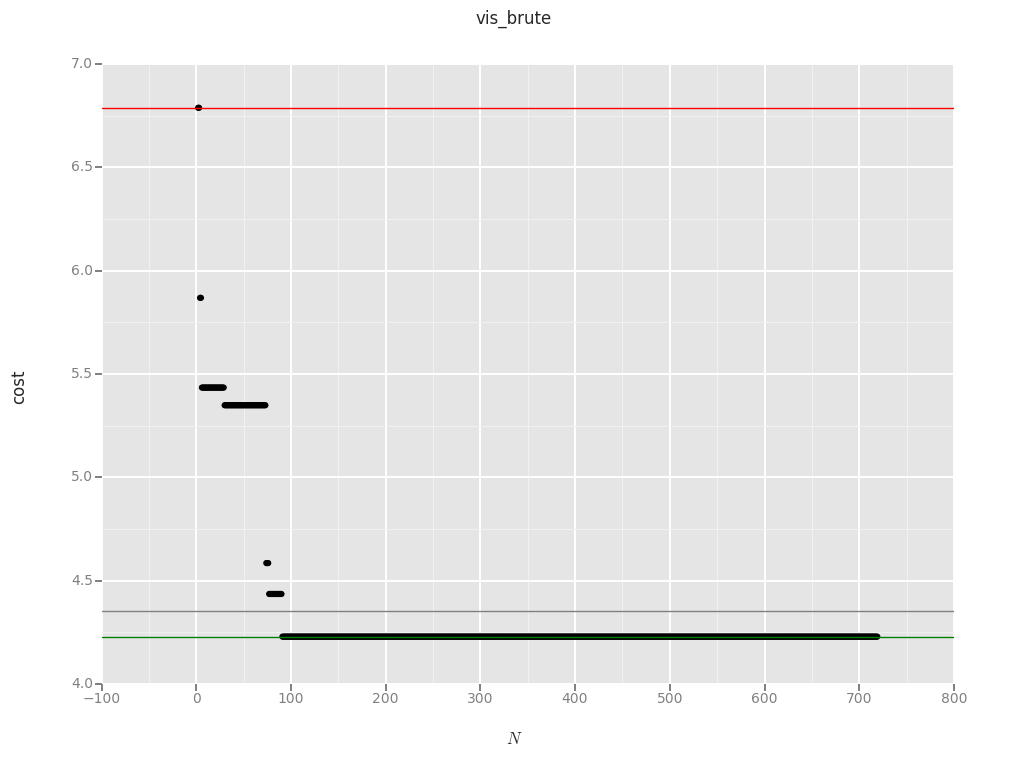

In [25]:
vis_brute(range(2, len(list(permutations(tsp_prob.graph.nodes())))));

If we tweak the code slightly, we can see what it's doing without a `reduce` step:

In [26]:
# %load -s brute_force_N_no_reduce algs.py
def brute_force_N_no_reduce(p, n, perf=False):
    import itertools as it
    #Generate all possible tours (complete graph)
    tours = list(it.permutations(p.nodes())) #O(V!)
    costs = []
    
    if not perf:
        cost_data = pd.DataFrame(columns=["$N$", "cost", "opt_cost"])
    
    #Evaluate all tours
    for tour in tours[:n]:
        cost = 0
        for n1, n2 in zip(tour, tour[1:]): #O(V)
            cost += p[n1][n2]['weight']
        costs.append(cost)
        
    if not perf:
        cost_data = cost_data.append({"$N$" : n,
                                      "cost" : costs[-1],
                                      "opt_cost" : min(costs)},
                                     ignore_index = True)
        return (cost_data, pd.DataFrame())
        
    #Choose tour with lowest cost
    return tours[np.argmin(costs)]


In [27]:
@get_stats(name="Brute force, no reduce",
           data=tsp_prob,
           plots=[scatter_vis, dist_across_cost])
def vis_brute_no_reduce(*args, **kwargs):
    return brute_force_N_no_reduce(*args, **kwargs)

importing os on engine(s)
importing posix on engine(s)


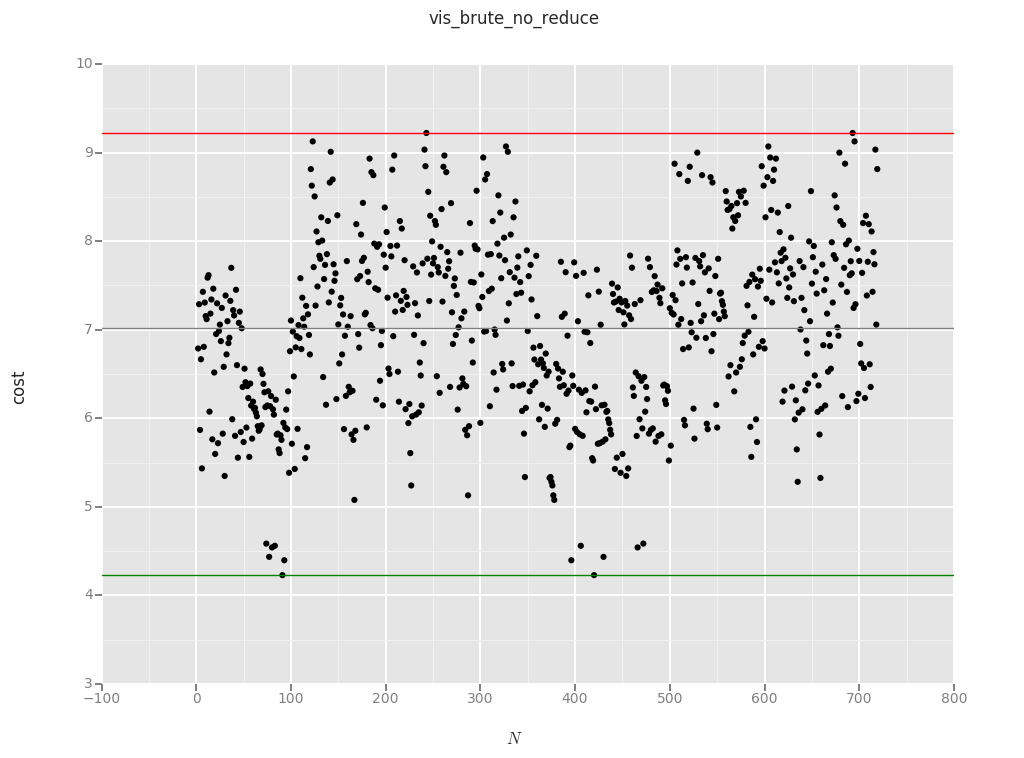

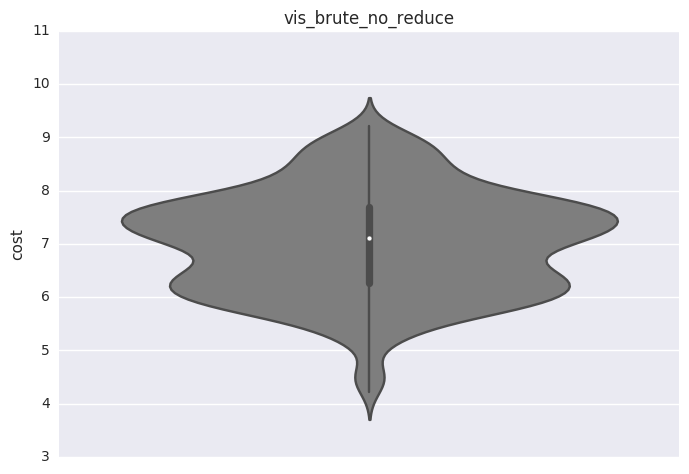

In [28]:
cost_stats, _ = vis_brute_no_reduce(range(2, len(list(permutations(tsp_prob.graph.nodes())))))

Given this is a randomly distributed dataset, it makes sense that the distribution across costs looks like a gaussian. Let's confirm by checking how correlated they are

In [29]:
from scipy.stats import pearsonr

In [30]:
pearsonr(cost_stats.cost, cost_stats.opt_cost)

(-0.17397734479859261, 2.7387411264070091e-06)

In [31]:
pearsonr(cost_stats["$N$"], cost_stats.cost)

(0.1870500140692247, 4.4648537969633032e-07)